<a href="https://colab.research.google.com/github/SumSera/winc-DA-opdrachten/blob/main/k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://static.wincacademy.nl/logos/main-logo.png" height=200px style="height: 200px"/>

In [ ]:
!pip install matplotlib --user > /dev/null
!pip install numpy --user > /dev/null
!pip install sklearn --user > /dev/null

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# K-Means Clustering

## Data Exploration

Here's a dataset containing measurements of different plants. We load the data from a library called *sklearn* and print the decription they provide.

In [ ]:
iris = datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Based on the description above, answer the following questions:

**1. Which plant species are included in this dataset?**

** Iris-Setosa, Iris-Versicolour and Iris-Virginicairis.*

**2. Which properties of these species are included in this dataset?**

*Sepal length and width and petal length and width. And class.*

**3. How many data points do we have in total, and how many per plant species?**

*150 x 5 attributes = 750 datapoints. There are 250 datapoints per species, of which there are three*


Let's assign the data and the matching classification to different variables.

- The measurements we have is our *data*.
- The matching classification -- in this case a plant species -- is known as a *target*.

In [ ]:
data, targets = iris['data'], iris['target']
print(f'First 10 datapoints:\n{data[:10]}\nMatching targets:\n{targets[:10]}')

First 10 datapoints:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
Matching targets:
[0 0 0 0 0 0 0 0 0 0]


**4. What is the name of the plant species that we just printed the data from?**

*The first class (0), so probably iris-setosa.*

It's hard to get a good feel for what the data looks like just by looking at the numbers.

Let's make a plot to get a feel for what we're looking at. For each datapoint we have 4 measurements of the size of different parts of the plant. It's hard to visualise 4-dimensional data, so let's look at 2 different attributes at a time.

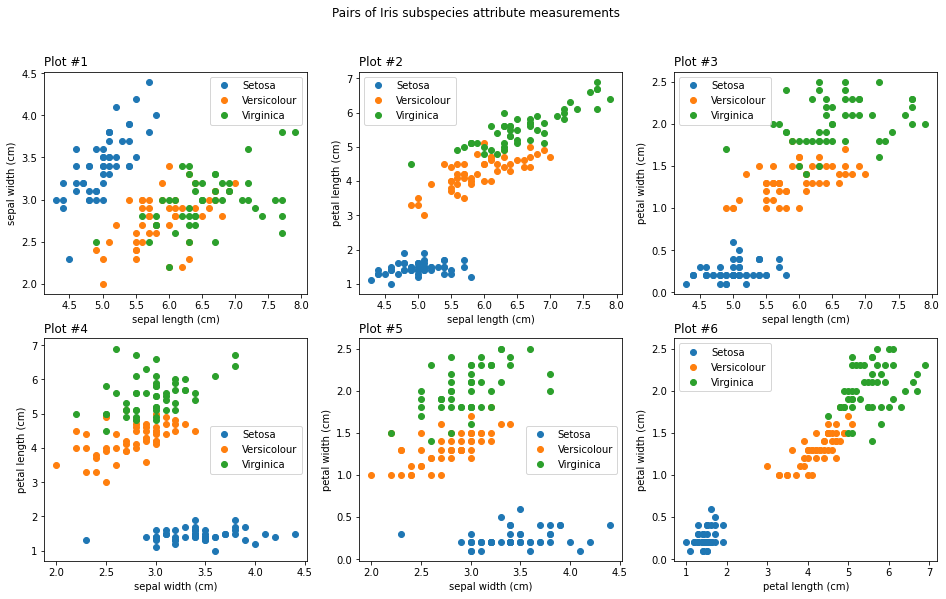

In [ ]:
from itertools import combinations

fig, axs = plt.subplots(2, 3, figsize=(16,9))

setosa = data[:50]
versicolour = data[50:100]
virginica = data[100:]

for (i, ax), (f0, f1) in zip(enumerate(axs.flatten()), combinations(list(range(4)), 2)):
    ax.plot(setosa[:, f0], setosa[:, f1], 'o', label='Setosa')
    ax.plot(versicolour[:, f0], versicolour[:, f1], 'o', label='Versicolour')
    ax.plot(virginica[:, f0], virginica[:, f1], 'o', label='Virginica')
    ax.set_xlabel(iris['feature_names'][f0])
    ax.set_ylabel(iris['feature_names'][f1])
    ax.set_title(f'Plot #{i+1}', loc='left')
    ax.legend()
    
fig.suptitle('Pairs of Iris subspecies attribute measurements');

We can learn from the plots that not all attributes separate the different subspecies as well as others.

**Questions**

**5. What does this mean, in your own words?**

*That there is overlap in the vaues of attributes of some species.*

**6. How can we learn this from the plots?**

*Green and orange dots are culstered without much separation. Only the blue dots are clearly distinguishable as having other values.*

Imagine we didn't have the labels. In other words, we only have the sepal and petal measurements, and no clue about which plant species they belong to. You can see what the plots would look like below in the plot titled "Pairs of Iris subspecies attribute measurements without labels".

**7. In this case, which pair of measurements should we use to draw new groups from scratch? In other words: which plot would you use to re-colorize the dots in a way that approaches the original distribution? Why?**

*Plot #2. Because both plots have clear separation and the second and third clas could be derived from the suggestion of one having higher values, above a threshold to yet be determined*

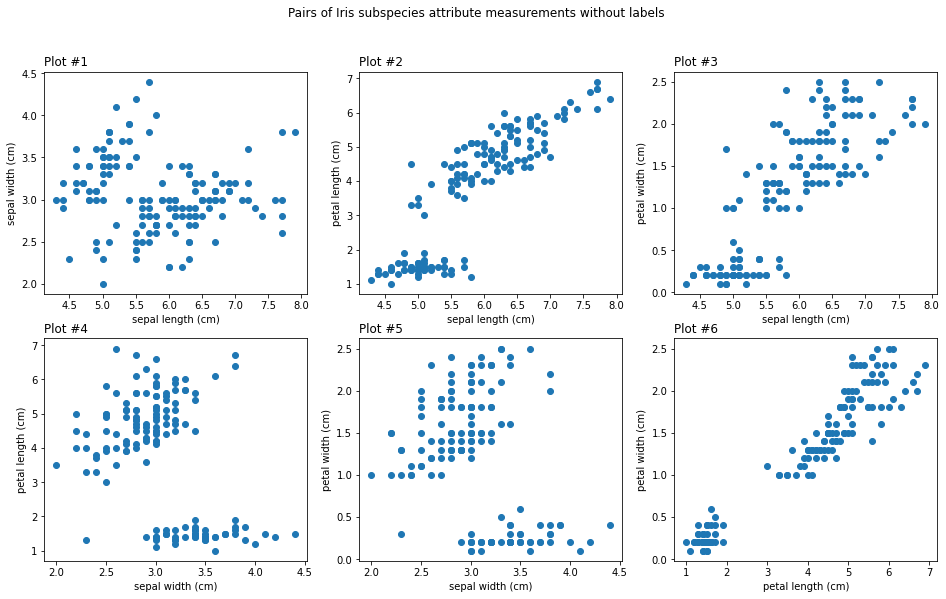

In [ ]:
from itertools import combinations

fig, axs = plt.subplots(2, 3, figsize=(16,9))

for (i, ax), (f0, f1) in zip(enumerate(axs.flatten()), combinations(list(range(4)), 2)):
    ax.plot(data[:, f0], data[:, f1], 'o')
    ax.set_xlabel(iris['feature_names'][f0])
    ax.set_ylabel(iris['feature_names'][f1])
    ax.set_title(f'Plot #{i+1}', loc='left')
    
fig.suptitle('Pairs of Iris subspecies attribute measurements without labels');

## Clustering

The task described in question 6 is called *clustering*. It's about finding clusters of data points that belong together. Here are some examples of when it's used:

- A company has a database of customers. They want to divide their customers into 5 groups in order to understand them better and adjust their plans accordingly.
- A social network would like to automatically divide their users into groups so that advertising agencies can select them as their target audience when they buy an ad with the social network.
- A chemical lab would like to automatically identify unknown substances.
- A botanist would like to classify plants into different species based on measurements they did.

Here we will pretend to work on that last case. We are the botanists, and we have plant measurements *without labels*. It is our job to draw clusters of unique plants.

**8. How would you solve this problem if you had the dots on a piece of paper? Explain your intuitive approach in a number of steps. Be precise! If you want to say "draw a circle around dots that are close", ask yourself: what is 'close'? How many circles will you draw? How many dots should be in each circle?**

*I would first draw circles around the clearly separated dots in the smallest group. Count the dots therein and have that number as a loose reference, assuming this is a seperate species. Then draw a circle around the lower values of the bigger clusters, going up and separating when the enclosed dots near the reference value.*

## K-Means Clustering

$k$-means is an unsupervised machine learning clustering algorithm.


- *Unsupervised* means the method does not rely on a dataset of known outcomes; $k$-means clusters datapoints without using labeled examples of 'correctly clustered' datapoints.
- *Machine learning* is the concept of programming a computer to find a pattern for us, instead of finding the pattern ourselves.
- *Clustering* is the task described in the previous section.
- An *algorithm* is a series of steps to perform to accomplish a task.

Here's how it works on an intuitive level:

1. Choose the number of clusters, $k$, and a threshold.
2. Pick $k$ unique starting positions. These positions are the *centroids*.
3. For each datapoint, calculate the distance to each centroid.
4. **Assign**: assign each datapoint to the nearest centroid. The groups that form are the clusters.
5. **Update**. For each cluster, update the centroid by computing the *mean* of all the datapoint in it. This mean is the new centroid.
6. Loop the **assign** $\leftrightarrow$ **update** steps until the centroids' movement falls below the threshold.

Here's what the implementation looks like for our plant data. We will use the *petal length* and *petal width* features of our data.

In [ ]:
import random

def k_means_clustering(data, k, threshold, max_iterations=100, plots=False):
    delta = float('inf')
    
    # 2. Pick k unique starting positions
    unique_data = np.unique(data, axis=0)
    centroid_indices = np.random.randint(0, unique_data.shape[0], k)
    while len(set(centroid_indices)) != k:
        centroid_indices = np.random.randint(0, unique_data.shape[0], k)
    new_centroids = unique_data[centroid_indices]
    del unique_data
        
    iterations = 0
    # While the centroids are moving more than some predefined value 
    while delta > threshold and iterations < max_iterations:
        clusters = [[] for _ in range(k)]
    
        # 3. For each datapoint...
        for d in data:
            # ... calculate the distance to each centroid ...
            norms = [np.linalg.norm(d - c) for c in new_centroids]
            # 4. ... and assign the datapoint to the nearest centroid's cluster
            clusters[np.argmin(norms)].append(d)
        clusters = np.array([np.array(x) for x in clusters], dtype=object)
        
        if plots:
            # Extra: plot what our clusters look like at this moment.
            fig, ax = plt.subplots(figsize=(8,6))
            fig.suptitle(f'Iteration {iterations}')
            for (j, cluster), centroid in zip(enumerate(clusters), new_centroids):
                color = ax.plot(cluster[:,0], cluster[:,1], '.', label=f'cluster {j}')[0].get_color()
                ax.plot(centroid[0], centroid[1], '^', label=f"cluster {j}'s centroid", color=color)
            ax.set_xlabel(iris['feature_names'][2])
            ax.set_ylabel(iris['feature_names'][3])
            ax.legend()
            plt.show()
        
        # 5. Update the centroid
        old_centroids = new_centroids
        new_centroids = [np.mean(c, axis=0) for c in clusters]
    
        # 6. Check how much the centroids moved.
        delta = np.linalg.norm(np.array(new_centroids, dtype=object) - np.array(old_centroids, dtype=object))
        iterations += 1
    return iterations, clusters


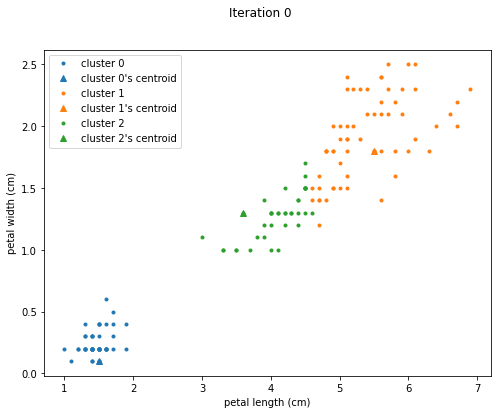

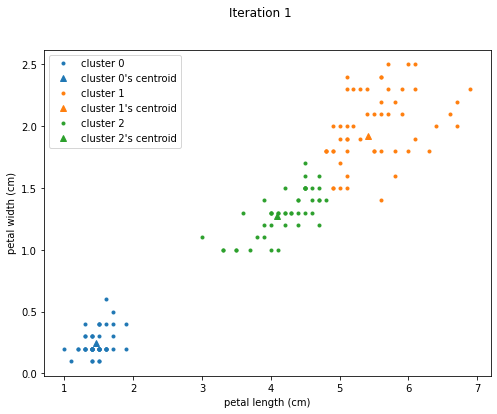

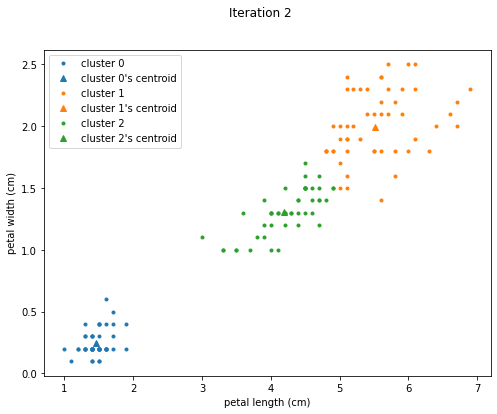

Executed in 3 iterations


In [ ]:
data_2d = data[:,2:]

# ADJUST THE VARIABLE BELOW TO PLAY WITH THE NUMBER OF CLUSTERS
k = 3
# DON'T MODIFY ANYTHING BELOW THIS LINE

iterations, clusters = k_means_clustering(data_2d, k, threshold=0.05, plots=True)
print(f'Executed in {iterations} iterations')

**9. The algorithm was set to find 2 clusters ($k=2$). Does it makes sense to keep $k$ at this level? Why/why not? If not, what would you change it to?**

*Ther's clear clustering with k=2. But also with k=3. There is however a large variation in petal length and width in the second cluster, which suggests another possible cluster*

**10. Run the algorithm a few times with the right value for $k$. Note the number of iterations used each time. Is it the same? Why/why not?**

*The number of iterations varies because the data is imported at random. This lead to variations in the plots when clustering.*

**11. Compare the plots after each iteration. Why are the centroids moving and the clusters changing?**

*Centroids move because of the random import. Clusters form around the centroids, so they move too.*

**11. Is it guaranteed that for a particular value of $k$ we find the same clusters every time we run it? Why/why not?**

*No, that is not guaranteed. But after many reruns theoutcome may become predictable.* 

## Evaluating K-Means

We now have an algorithm for finding clusters in our plant data. But how good is it? Let's compare some results from k-means clustering to the real, ground-truth labels that we have.

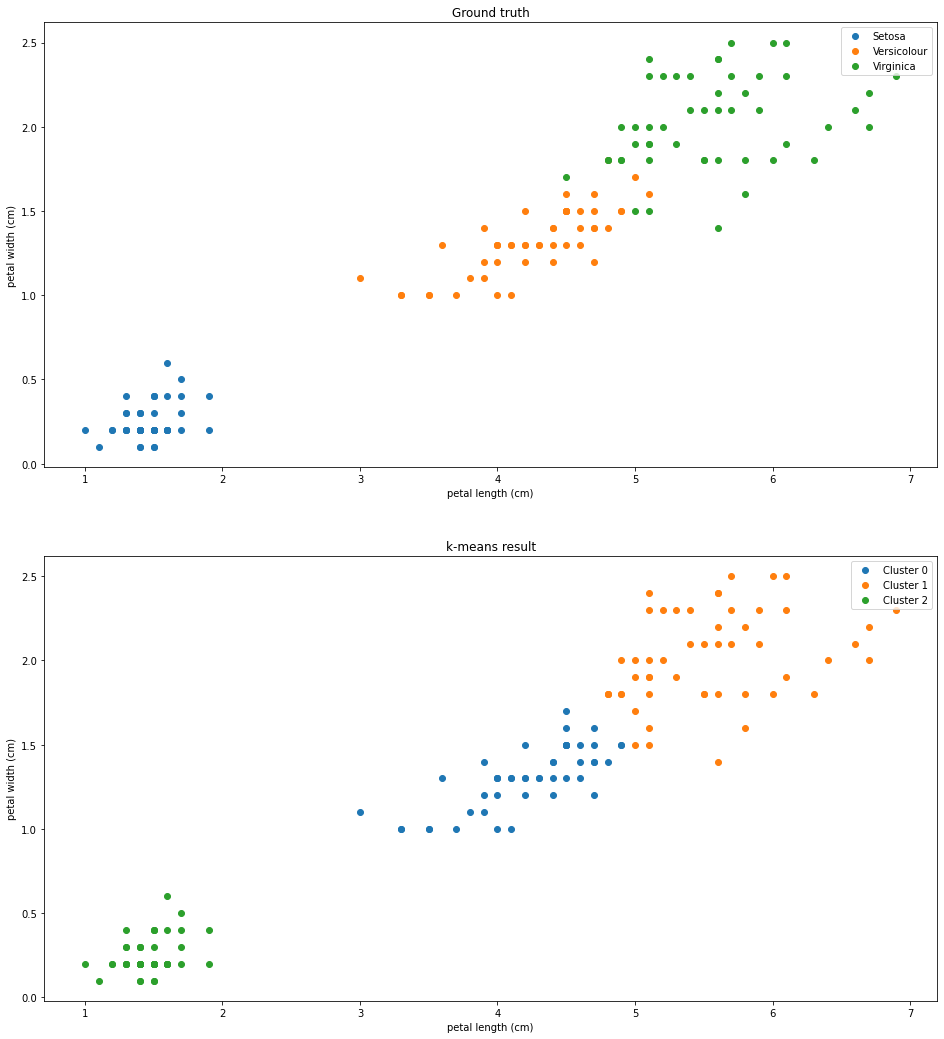

In [ ]:
fig, axs = plt.subplots(2, figsize=(16,18))

axs[0].plot(setosa[:, 2], setosa[:, 3], 'o', label='Setosa')
axs[0].plot(versicolour[:, 2], versicolour[:, 3], 'o', label='Versicolour')
axs[0].plot(virginica[:, 2], virginica[:, 3], 'o', label='Virginica')
axs[0].set_xlabel(iris['feature_names'][2])
axs[0].set_ylabel(iris['feature_names'][3])
axs[0].legend()
axs[0].set_title('Ground truth')

_, clusters = k_means_clustering(data_2d, 3, threshold=0.05, plots=False)
axs[1].plot(clusters[0][:, 0], clusters[0][:, 1], 'o', label='Cluster 0')
axs[1].plot(clusters[1][:, 0], clusters[1][:, 1], 'o', label='Cluster 1')
axs[1].plot(clusters[2][:, 0], clusters[2][:, 1], 'o', label='Cluster 2')
axs[1].set_xlabel(iris['feature_names'][2])
axs[1].set_ylabel(iris['feature_names'][3])
axs[1].legend()
axs[1].set_title('k-means result');

**12. How well did k-means algorithm do? Compare its result with the ground truth. Where did k-means go wrong, and why do you think it went wrong there?**

*The algorithm does quite well. It finds separated areas quite well, but has more trouble with larger spread out clusters boundaries.*

**13. How would you evaluate k-means clustering if you didn't have ground truth data? What does your answer say about using k-means in real life?**

*Without ground truth data, visual evaluation is probably necessary .*

**14. Below you see data that is shaped like a mouse. On the left are the real labels. In the middle is a k-means clustering result. On the right you see the result from a different clustering algorithm (EM). Which one did better? Why did the k-means clustering attempt turn out this way?**

*EM did better. Because k-means is more area oriented due to the circular 'looking around' of the algorithm.*

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/2560px-ClusterAnalysis_Mouse.svg.png"/>

In this lesson you learned about the k-means clustering algorithm. If you use a data analytics tool in the future that offers it as a tool to perform clustering, now you'll know how it works under the hood and what its limitations are.